In [1]:
import pandas as pd

# Load the Excel file
file_path = "GP25_Business-Case-Marketing Data Science Specialist.xlsx"
df = pd.read_excel(file_path, sheet_name='Data', engine="openpyxl")

# Display basic info about the dataset
print(df.info())  # Column names, data types, missing values
print(df.head())  # First few rows to check structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   YEAR_WEEK                             184 non-null    object 
 1   PERIOD                                184 non-null    int64  
 2   DATE                                  184 non-null    int64  
 3   RED_BULL_sales_litres                 184 non-null    float64
 4   RED_BULL_DWD                          184 non-null    float64
 5   RED_BULL_price                        184 non-null    float64
 6   RED_BULL_pct_vol_promo                184 non-null    float64
 7   RED_BULL_vol_deal                     184 non-null    float64
 8   COMPETITOR_sales_litres               184 non-null    float64
 9   COMPETITOR_DWD                        184 non-null    float64
 10  COMPETITOR_price                      184 non-null    float64
 11  COMPETITOR_pct_vol_

In [2]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # Show only columns with missing data

# Option 2: Drop rows with missing values
df.dropna(inplace=True)

Series([], dtype: int64)


In [3]:
df["DATE"] = pd.to_datetime(df["YEAR_WEEK"] + "-1", format="%Y-W%W-%w")



In [4]:
print(df['DATE'].head())

0   2021-01-04
1   2021-01-11
2   2021-01-18
3   2021-01-25
4   2021-02-01
Name: DATE, dtype: datetime64[ns]


In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from scipy.stats import boxcox

Matplotlib is building the font cache; this may take a moment.


In [10]:
# Feature scaling
scaler = StandardScaler()
features = ["RED_BULL_DWD", "RED_BULL_price", "RED_BULL_pct_vol_promo", "RED_BULL_vol_deal",
            "COMPETITOR_DWD", "COMPETITOR_price", "COMPETITOR_pct_vol_promo", "COMPETITOR_vol_deal",
            "paid_grp_tv", "paid_imp_disp", "paid_imp_sem", "paid_imp_social", "paid_imp_webtv",
            "paid_spend_cinema", "paid_spend_ooh"]

df[features] = scaler.fit_transform(df[features])

In [11]:
# Log transformation for skewed variables
df["RED_BULL_sales_litres"] = np.log1p(df["RED_BULL_sales_litres"])

# Lag features (assume marketing effects lag by 1 week)
for col in ["paid_grp_tv", "paid_imp_disp", "paid_imp_sem", "paid_imp_social"]:
    df[col + "_lag1"] = df[col].shift(1)

# Interaction terms
df["promo_price_interaction"] = df["RED_BULL_pct_vol_promo"] * df["RED_BULL_price"]

# Drop first row(s) due to lagging
df.dropna(inplace=True)

In [12]:
# Define X and y
X = df[["RED_BULL_DWD", "RED_BULL_price", "RED_BULL_pct_vol_promo", "promo_price_interaction",
        "paid_grp_tv", "paid_imp_disp", "paid_imp_sem", "paid_imp_social",
        "paid_grp_tv_lag1", "paid_imp_disp_lag1", "paid_imp_sem_lag1", "paid_imp_social_lag1"]]

y = df["RED_BULL_sales_litres"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Ridge Regression
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge.fit(X_train, y_train)

# Model evaluation
r2_score = ridge.score(X_test, y_test)
print(f"Model R²: {r2_score:.4f}")

# Feature Importance
coef_df = pd.DataFrame({"Feature": X.columns, "Coefficient": ridge.coef_})
coef_df.sort_values(by="Coefficient", ascending=False, inplace=True)
print(coef_df)

Model R²: 0.5019
                    Feature  Coefficient
8          paid_grp_tv_lag1     0.018910
3   promo_price_interaction     0.014940
11     paid_imp_social_lag1     0.009183
6              paid_imp_sem     0.005868
4               paid_grp_tv     0.005130
7           paid_imp_social     0.004358
2    RED_BULL_pct_vol_promo    -0.000230
9        paid_imp_disp_lag1    -0.003176
10        paid_imp_sem_lag1    -0.003834
0              RED_BULL_DWD    -0.007348
5             paid_imp_disp    -0.017562
1            RED_BULL_price    -0.039641


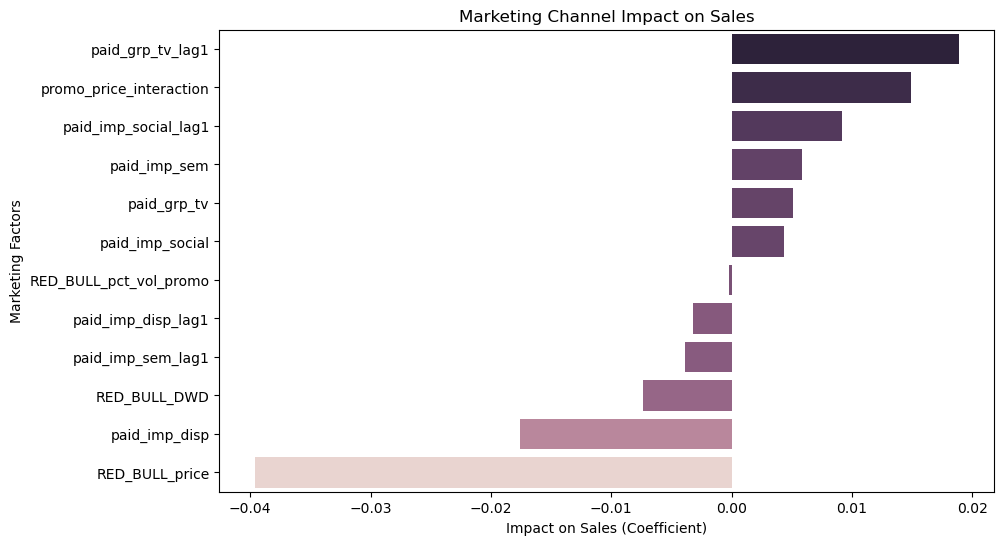

In [19]:
# Bar Plot of Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(data=coef_df, x="Coefficient", y="Feature", hue="Coefficient", legend=False)
plt.title("Marketing Channel Impact on Sales")
plt.xlabel("Impact on Sales (Coefficient)")
plt.ylabel("Marketing Factors")
plt.show()